## Importing Libraries 

In [517]:
pip install seaborn statsmodels scipy bertopic sentence-transformers nltk scikit-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [518]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation




## Load and Merge Datasets

In [519]:
#Merging the dataset 
df1 = pd.read_csv("../data/Citations updated.csv", encoding='ISO-8859-1') #citations
df2 = pd.read_csv("../data/reproducibility_stamp.csv", encoding='ISO-8859-1') #repStamp
merged_df = df1.merge(df2[['Title','DOI']], on ='Title', how='left',suffixes=('', '_from_Rep_Sta'))
merged_df['DOI'] = merged_df['DOI'].combine_first(merged_df['DOI_from_Rep_Sta'])
merged_df.head()
merged_df.drop(columns=['DOI_from_Rep_Sta'],inplace=True)
merged_df.to_csv(r'../data/merged_data.csv', index=False, encoding='ISO-8859-1')
#merged citations.csv with reproducibility_stamp, now the rows with a DOI are of reports with reproducibility stamps


Null Value Check

In [520]:
merged_df.columns

Index(['ï»¿Cites', 'Authors', 'Title', 'Year', 'Source', 'Publisher',
       'ArticleURL', 'CitesURL', 'GSRank', 'QueryDate', 'Type', 'DOI', 'ISSN',
       'CitationURL', 'Volume', 'Issue', 'StartPage', 'EndPage', 'ECC',
       'CitesPerYear', 'CitesPerAuthor', 'AuthorCount', 'Age', 'Abstract',
       'FullTextURL', 'RelatedURL'],
      dtype='object')

In [521]:
#Checking for null values, verifying data types 
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ï»¿Cites        1400 non-null   int64  
 1   Authors         1400 non-null   object 
 2   Title           1400 non-null   object 
 3   Year            1400 non-null   int64  
 4   Source          1398 non-null   object 
 5   Publisher       1391 non-null   object 
 6   ArticleURL      1337 non-null   object 
 7   CitesURL        1204 non-null   object 
 8   GSRank          1400 non-null   int64  
 9   QueryDate       1400 non-null   object 
 10  Type            278 non-null    object 
 11  DOI             88 non-null     object 
 12  ISSN            0 non-null      float64
 13  CitationURL     0 non-null      float64
 14  Volume          0 non-null      float64
 15  Issue           0 non-null      float64
 16  StartPage       0 non-null      float64
 17  EndPage         0 non-null      f

Correlation Matrix

In [522]:
numerics = [
    'ï»¿Cites',         # Total citations
    'CitesPerYear',     # Annual citation rate
    'CitesPerAuthor',   # Citations normalized by author count
    'AuthorCount',      # Number of authors
    'GSRank',           # Google Scholar Rank (lower is better)
    'ECC',              # Estimated Citation Count (probably related to Google Scholar)
    'Age'               # Years since publication
]


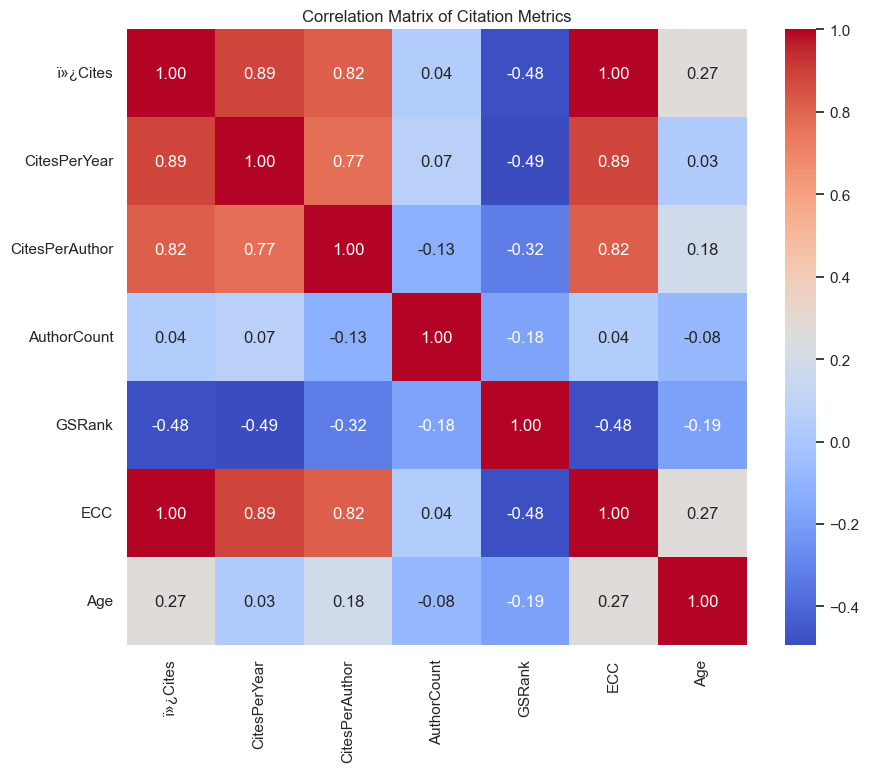

In [523]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = merged_df[numerics].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Citation Metrics")
plt.show()


## Data Cleaning and Pre-processing

Remove columns with no futher use

In [524]:

coloumns_to_drop = ['Source', 'ArticleURL', 'CitesURL', 'ISSN', 'Volume', 'Issue', 'StartPage', 'EndPage', 'CitationURL', 'FullTextURL', 'RelatedURL']
merged_df.drop(columns=coloumns_to_drop, inplace=True, errors='ignore')


Create a binary variable for reproducbility stamp

In [525]:
merged_df['IsReproducible?'] = merged_df['DOI'].notnull().astype(int) # added a reproducible boolean
merged_df.to_csv('./test.csv', index=False, encoding='ISO-8859-1')

## Statistical Testing

In [526]:

#from scipy.stats import mannwhitneyu

# Separate the two groups
reproducible = merged_df[merged_df['IsReproducible?'] == 1]['CitesPerYear']
non_reproducible = merged_df[merged_df['IsReproducible?'] == 0]['CitesPerYear']

# Perform the Mann-Whitney U Test
stat, p = mannwhitneyu(reproducible, non_reproducible)

print(f"U Statistic = {stat}")
print(f"P-value = {p}")

# Interpretation
if p < 0.05:
    print("Result: Significant difference between reproducible and non-reproducible papers ")
else:
    print("Result: No significant difference detected")


U Statistic = 62560.0
P-value = 0.18719227466326283
Result: No significant difference detected


In [527]:

# Define features and target
X = merged_df[['IsReproducible?', 'AuthorCount', 'Age']]
X = sm.add_constant(X)  # Adds intercept
y = merged_df['CitesPerYear']

# Fit the model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           CitesPerYear   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.208
Date:                Wed, 14 May 2025   Prob (F-statistic):             0.0223
Time:                        12:23:47   Log-Likelihood:                -4217.2
No. Observations:                1400   AIC:                             8442.
Df Residuals:                    1396   BIC:                             8463.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.6290      0.451     

## Exploratory Data Analysis (EDA)

Boxplot: CitesPerYear vs Reproducibility

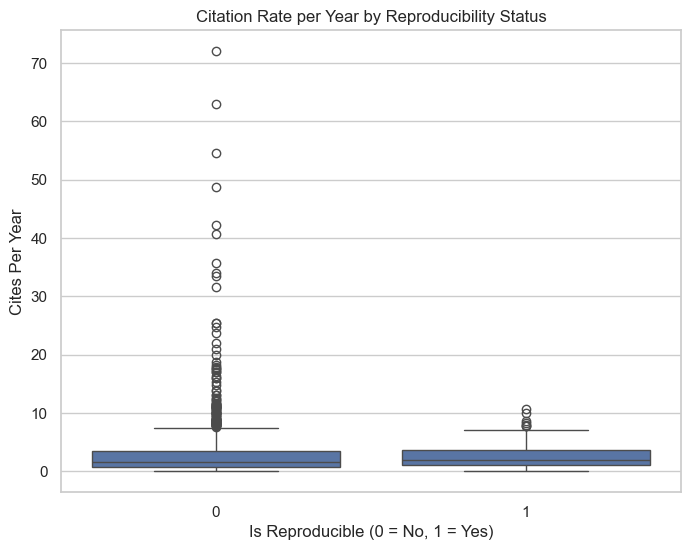

In [528]:
plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='IsReproducible?', y='CitesPerYear')
plt.title('Citation Rate per Year by Reproducibility Status')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Cites Per Year')
plt.show()


 Scatterplot: Age vs CitesPerYear, Colored by Reproducibility

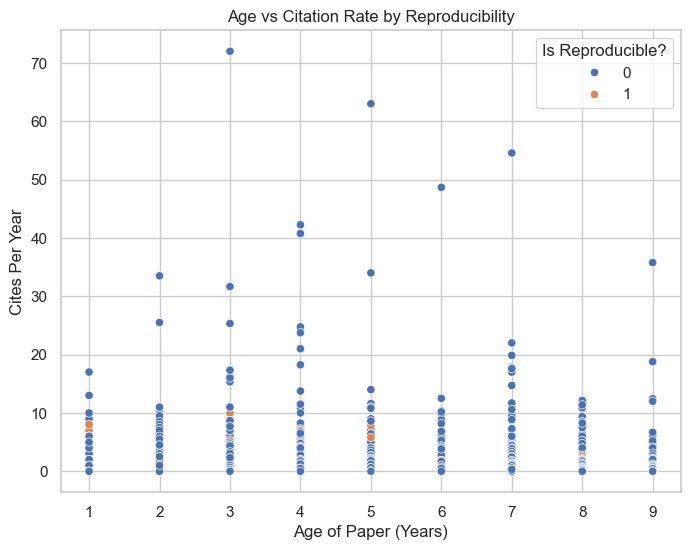

In [529]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x='Age', y='CitesPerYear', hue='IsReproducible?')
plt.title('Age vs Citation Rate by Reproducibility')
plt.xlabel('Age of Paper (Years)')
plt.ylabel('Cites Per Year')
plt.legend(title='Is Reproducible?')
plt.show()


Barplot: Average CitesPerYear for Reproducible vs Non-Reproducible

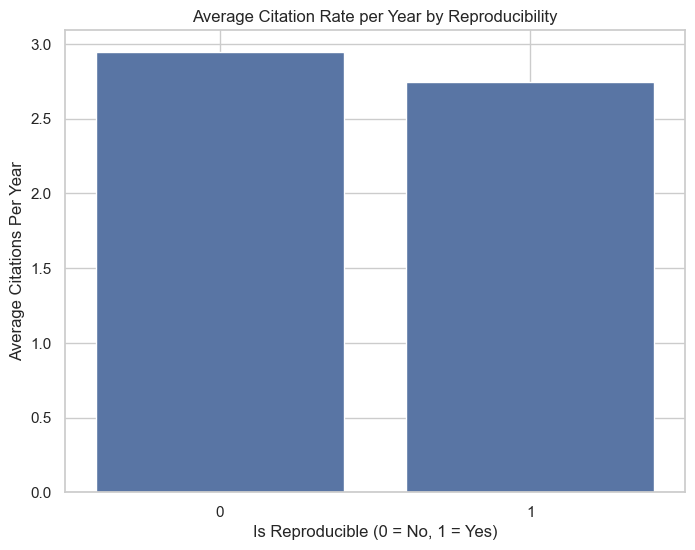

In [530]:
plt.figure(figsize=(8,6))
avg_cites = merged_df.groupby('IsReproducible?')['CitesPerYear'].mean().reset_index()

sns.barplot(data=avg_cites, x='IsReproducible?', y='CitesPerYear')
plt.title('Average Citation Rate per Year by Reproducibility')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Average Citations Per Year')
plt.grid(True)
plt.show()


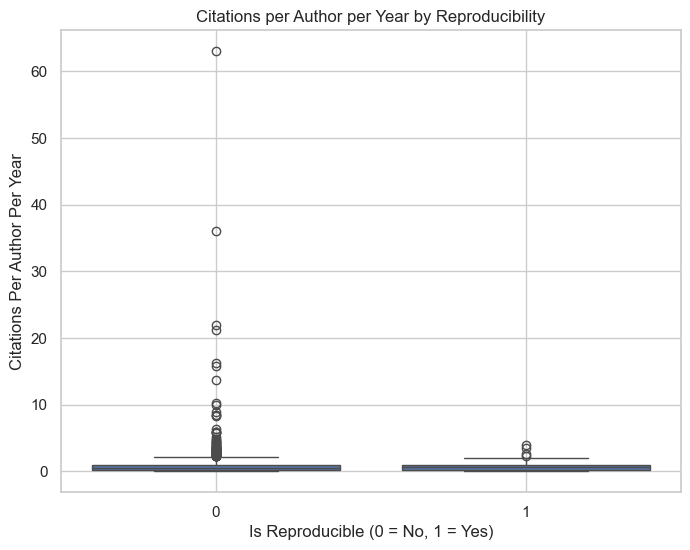

In [531]:
merged_df['CitesPerAuthorPerYear'] = merged_df['CitesPerYear'] / merged_df['AuthorCount']

plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='IsReproducible?', y='CitesPerAuthorPerYear')
plt.title('Citations per Author per Year by Reproducibility')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Citations Per Author Per Year')
plt.grid(True)
plt.show()


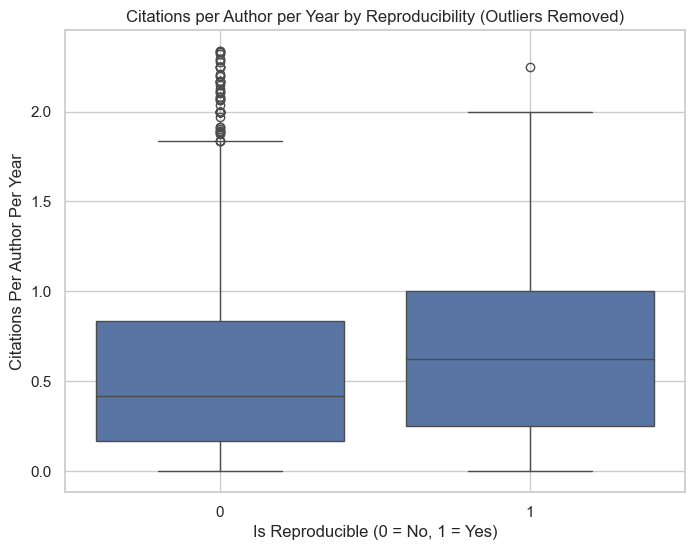

In [532]:

# Calculate 95th percentile value
q95 = merged_df['CitesPerAuthorPerYear'].quantile(0.95)

# Keep only rows below the 95th percentile
df_no_outliers = merged_df[merged_df['CitesPerAuthorPerYear'] <= q95]






plt.figure(figsize=(8,6))
sns.boxplot(data=df_no_outliers, x='IsReproducible?', y='CitesPerAuthorPerYear')
plt.title('Citations per Author per Year by Reproducibility (Outliers Removed)')
plt.xlabel('Is Reproducible (0 = No, 1 = Yes)')
plt.ylabel('Citations Per Author Per Year')
plt.grid(True)
plt.show()


In [534]:
from scipy.stats import mannwhitneyu

group0 = merged_df[merged_df['IsReproducible?'] == 0]['CitesPerAuthorPerYear']
group1 = merged_df[merged_df['IsReproducible?'] == 1]['CitesPerAuthorPerYear']

stat, p = mannwhitneyu(group0, group1)
print(f"U-Statistic: {stat}, p-value: {p}")


U-Statistic: 51766.5, p-value: 0.10393190616024148


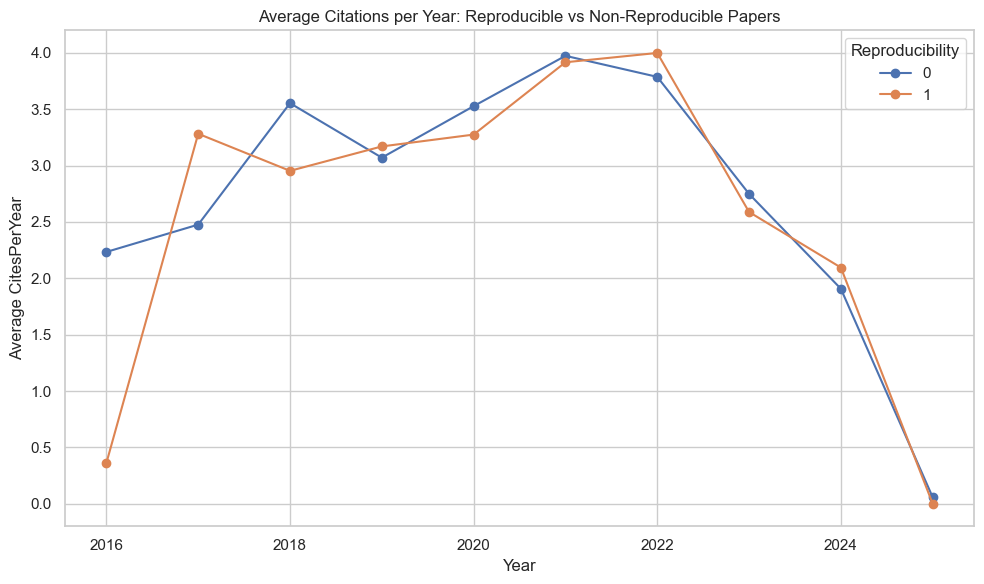

In [535]:
#import pandas as pd
#import matplotlib.pyplot as plt

# Load your dataset (skip this if already loaded)
# merged_df = pd.read_csv("your_dataset.csv")

# Drop rows with missing values in relevant columns
df = merged_df.dropna(subset=['Year', 'CitesPerYear', 'IsReproducible?'])

# Ensure Year is integer and is_reproducible is categorical
df['Year'] = df['Year'].astype(int)
df['IsReproducible?'] = df['IsReproducible?'].astype(str)

# Group by year and reproducibility and calculate average citations
grouped = df.groupby(['Year', 'IsReproducible?'])['CitesPerYear'].mean().reset_index()

# Pivot for plotting
pivot_df = grouped.pivot(index='Year', columns='IsReproducible?', values='CitesPerYear')

# Plotting
pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title("Average Citations per Year: Reproducible vs Non-Reproducible Papers")
plt.xlabel("Year")
plt.ylabel("Average CitesPerYear")
plt.legend(title="Reproducibility")
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: xlabel='Age', ylabel='CitesPerYear'>

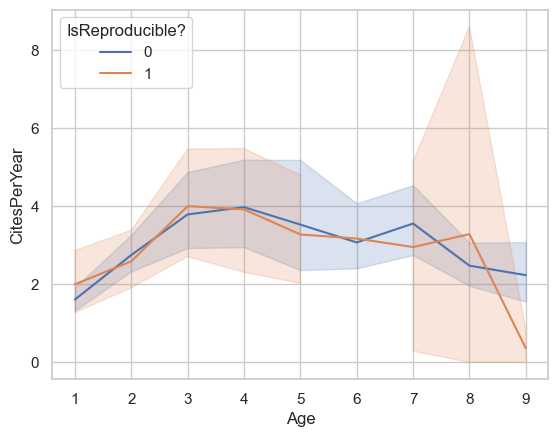

In [537]:
sns.lineplot(data=merged_df, x='Age', y='CitesPerYear', hue='IsReproducible?')

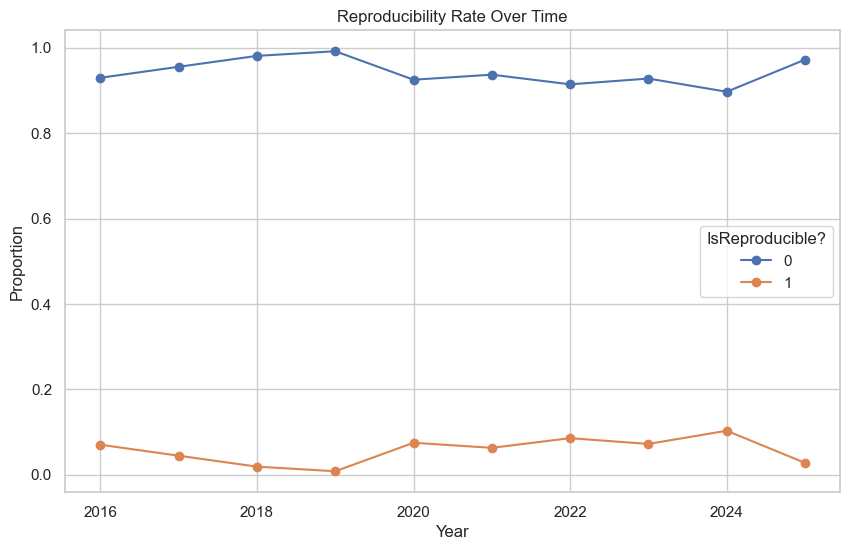

In [538]:
repro_rate = merged_df.groupby('Year')['IsReproducible?'].value_counts(normalize=True).unstack()
repro_rate.plot(kind='line', marker='o', figsize=(10,6))
plt.title("Reproducibility Rate Over Time")
plt.ylabel("Proportion")
plt.grid(True)
plt.show()


In [539]:
#import pandas as pd

# Load  merged dataset
#merged_df = pd.read_csv("../notebooks/test.csv", encoding="ISO-8859-1")

# Drop rows with missing citation data or year
#filtered_df = merged_df.dropna(subset=["CitesPerYear", "Year"])

# Get the most cited paper per year
most_cited_per_year = (
    df.sort_values(by="CitesPerYear", ascending=False)
    .groupby("Year", as_index=False)
    .first()
)

# Sort and select the top 10 most cited among those
top_10 = most_cited_per_year.sort_values(by="CitesPerYear", ascending=False).head(10)

# Show only Title, Year, and CitesPerYear
top_10[["Title", "Year", "CitesPerYear"]]


,Title,Year,CitesPerYear
6,A survey of visual analytics for explainable a...,2022,72.00
4,ConvPoint: Continuous convolutions for point c...,2020,63.00
2,SnapNet: 3D point cloud semantic labeling with...,2018,54.57
3,Human pose regression by combining indirect pa...,2019,48.67
5,A robot arm digital twin utilising reinforceme...,2021,42.25
0,Automatic reconstruction of parametric buildin...,2016,35.78
7,A review on generative adversarial networks fo...,2023,33.50
8,A survey of efficient fine-tuning methods for ...,2024,17.00
1,A multi-view recurrent neural network for 3D m...,2017,12.13
9,An introduction to and survey of biological ne...,2025,1.00


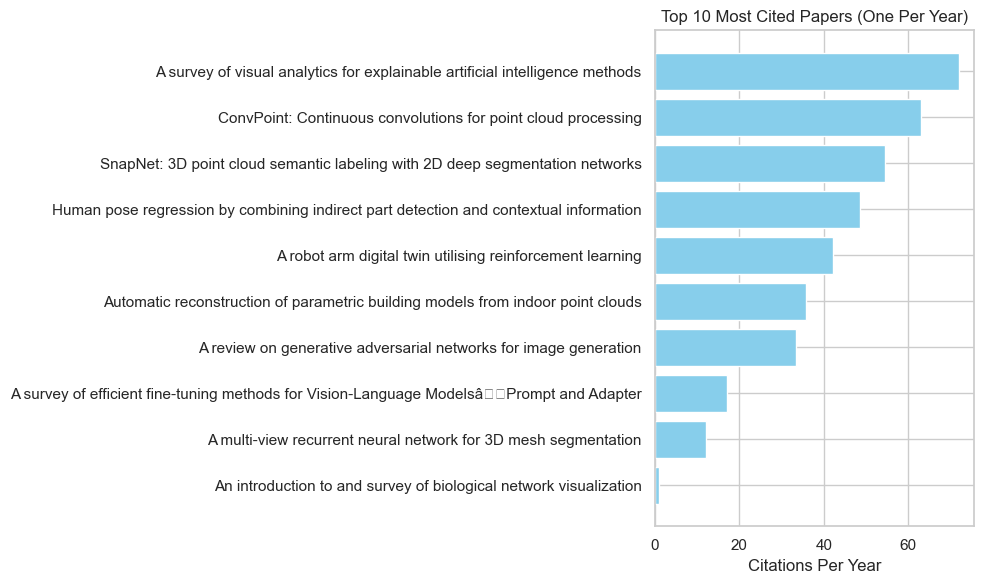

In [540]:
#import matplotlib.pyplot as plt

# Set plot size and style
plt.figure(figsize=(10, 6))
top_10_sorted = top_10.sort_values(by="CitesPerYear")  # So the largest bar is on top

# Plot horizontal bar chart
plt.barh(top_10_sorted["Title"], top_10_sorted["CitesPerYear"], color="skyblue")
plt.xlabel("Citations Per Year")
plt.title("Top 10 Most Cited Papers (One Per Year)")
plt.tight_layout()
plt.show()


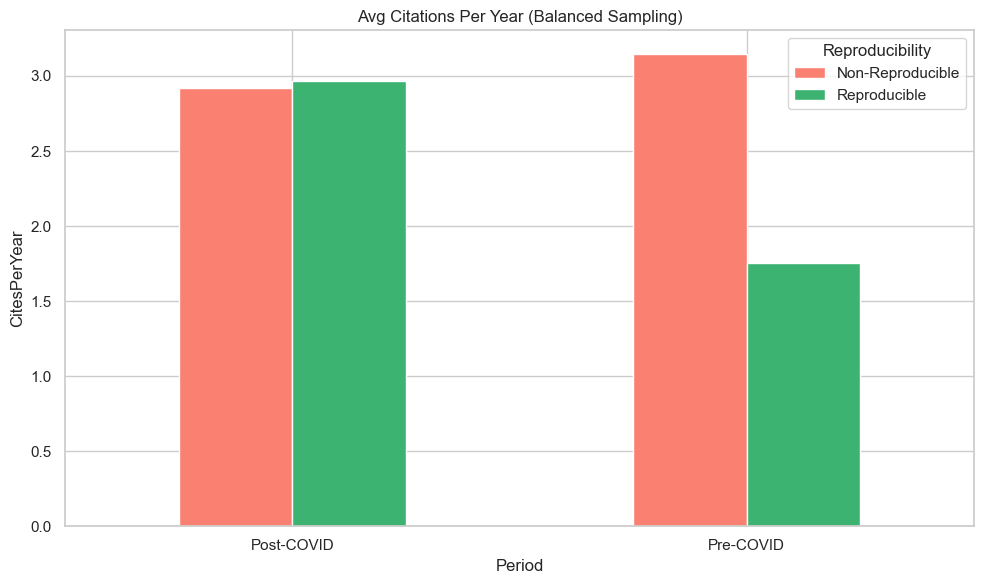

In [541]:
#import pandas as pd
#import matplotlib.pyplot as plt

# Step 1: Add reproducibility and period columns
merged_df["IsReproducible"] = merged_df["DOI"].notna()
merged_df["Period"] = merged_df["Year"].apply(lambda y: "Pre-COVID" if y < 2020 else "Post-COVID")

# Step 2: Balanced sampling function
def sample_equal_group(df, period, sample_size=None):
    subset = df[df["Period"] == period]
    groups = subset.groupby("IsReproducible")
    min_group_size = min(groups.size())

    n = sample_size if sample_size else min_group_size

    reproducible = groups.get_group(True).sample(n=n, random_state=42)
    non_reproducible = groups.get_group(False).sample(n=n, random_state=42)
    
    return pd.concat([reproducible, non_reproducible])

# Step 3: Apply sampling to both periods
sampled_pre = sample_equal_group(merged_df, "Pre-COVID")
sampled_post = sample_equal_group(merged_df, "Post-COVID")

# Step 4: Combine and calculate means
sampled_pre["Period"] = "Pre-COVID"
sampled_post["Period"] = "Post-COVID"
combined_sample = pd.concat([sampled_pre, sampled_post])

avg_citations = (
    combined_sample
    .groupby(["Period", "IsReproducible"])["CitesPerYear"]
    .mean()
    .unstack()
)

# Step 5: Plot
avg_citations.plot(kind="bar", figsize=(10,6), color=["salmon", "mediumseagreen"])
plt.title("Avg Citations Per Year (Balanced Sampling)")
plt.ylabel("CitesPerYear")
plt.xlabel("Period")
plt.xticks(rotation=0)
plt.legend(["Non-Reproducible", "Reproducible"], title="Reproducibility")
plt.tight_layout()
plt.show()


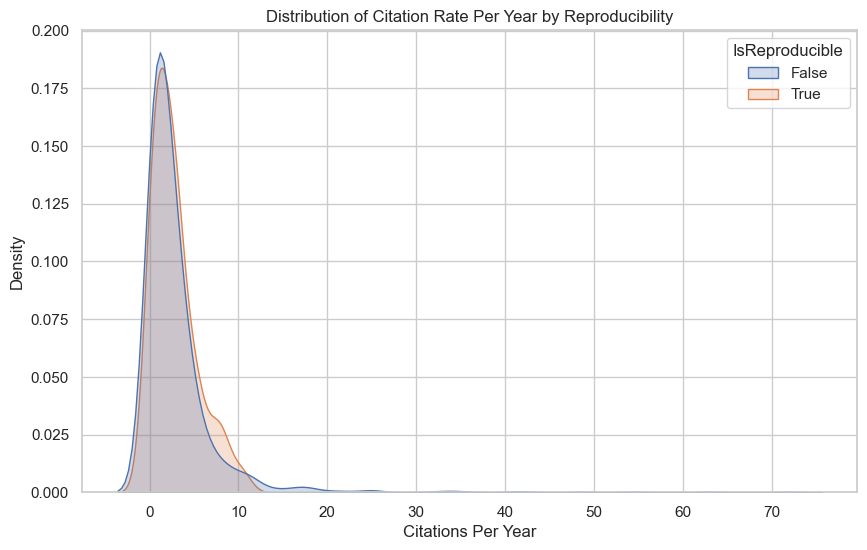

In [542]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_df, x='CitesPerYear', hue='IsReproducible', fill=True, common_norm=False)
plt.title("Distribution of Citation Rate Per Year by Reproducibility")
plt.xlabel("Citations Per Year")
plt.ylabel("Density")
plt.show()


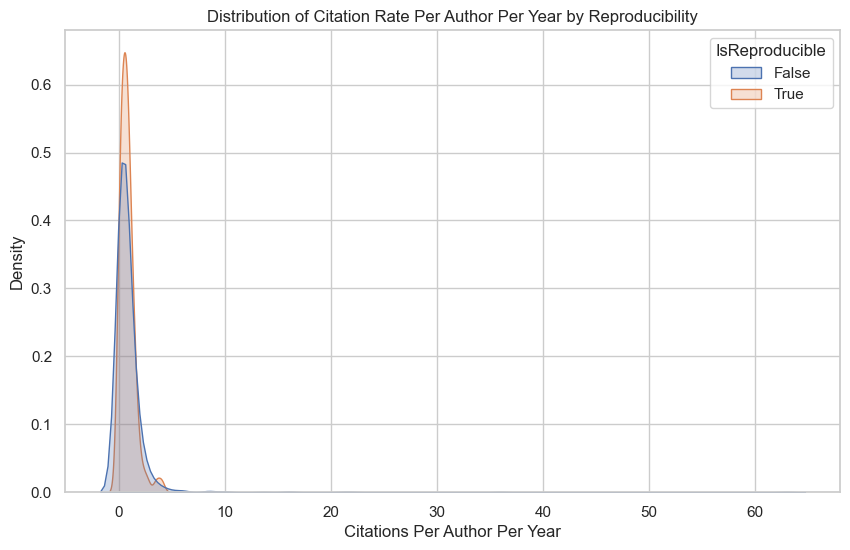

In [543]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_df, x='CitesPerAuthorPerYear', hue='IsReproducible', fill=True, common_norm=False)
plt.title("Distribution of Citation Rate Per Author Per Year by Reproducibility")
plt.xlabel("Citations Per Author Per Year")
plt.ylabel("Density")
plt.show()


In [544]:
merged_df.columns

Index(['ï»¿Cites', 'Authors', 'Title', 'Year', 'Publisher', 'GSRank',
       'QueryDate', 'Type', 'DOI', 'ECC', 'CitesPerYear', 'CitesPerAuthor',
       'AuthorCount', 'Age', 'Abstract', 'IsReproducible?',
       'CitesPerAuthorPerYear', 'IsReproducible', 'Period'],
      dtype='object')

## Topic Modelling

Bert Topic Modelling Attempts

In [545]:
import pandas as pd
from umap import UMAP
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
papers = pd.read_csv("test.csv", encoding="ISO-8859-1")
papers = papers.dropna(subset=["Abstract"])  # Remove missing abstracts

# Sort by citations 
papers = papers.sort_values(by="CitesPerYear", ascending=False)

# Extract abstracts for topic modeling
abstracts = papers["Abstract"].tolist()

# Set up BERTopic
vectorizer_model = CountVectorizer(stop_words="english")
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=15, n_components=2, metric="cosine", random_state=42)

# Train the model on all abstracts (with duplicates)
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(abstracts)

# Assign topics to full DataFrame
papers["Topic"] = topics

# Optional: Add clean keyword-based topic labels
def get_clean_topic_label(topic_id):
    topic = topic_model.get_topic(topic_id)
    return ", ".join([word for word, _ in topic[:3]]) if topic else "None"

papers["Topic_Label"] = papers["Topic"].apply(get_clean_topic_label)




2025-05-14 12:24:39,762 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 42/42 [00:01<00:00, 33.67it/s]
2025-05-14 12:24:41,024 - BERTopic - Embedding - Completed ✓
2025-05-14 12:24:41,024 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-14 12:24:43,126 - BERTopic - Dimensionality - Completed ✓
2025-05-14 12:24:43,127 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-14 12:24:43,147 - BERTopic - Cluster - Completed ✓
2025-05-14 12:24:43,148 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-14 12:24:43,181 - BERTopic - Representation - Completed ✓


In [546]:
# Remove duplicates for analysis
papers = papers.drop_duplicates(subset=["Abstract"])
papers = papers[papers["Topic"] != -1]  # Remove unassigned topics if desired

# Add refined topic names
refined_topic_labels = {
    0: "Virtual Reality (VR)", 1: "3D Modeling and CAD", 2: "Scientific Visualization",
    3: "Mesh Processing", 4: "Medical Image Analysis", 5: "3D Point Cloud Registration",
    6: "Photorealistic Rendering", 7: "Computer Graphics (General)", 8: "3D Object Retrieval",
    9: "Facial Animation", 10: "Augmented Reality (AR)", 11: "Deep Learning for 3D Vision",
    12: "Stereo Vision", 13: "Physics-Based Fluid Simulation", 14: "Neural Style Transfer",
    15: "Crowd Simulation", 16: "Non-Rigid Shape Matching", 17: "Semantic Segmentation",
    18: "Motion Capture and Animation", 19: "Spline Curve Modeling", 20: "Material Appearance Modeling",
    21: "Human Pose Estimation", 22: "Urban and Tree Modeling", 23: "Volumetric Rendering",
    24: "Single Image Dehazing", 25: "Underwater Image Enhancement", 26: "Image Smoothing and Filtering"
}
papers["Refined_Topic_Name"] = papers["Topic"].map(refined_topic_labels)



In [547]:
from collections import Counter
Counter(topics)


Counter({-1: 475,
         0: 103,
         1: 81,
         2: 74,
         3: 52,
         4: 46,
         5: 45,
         6: 40,
         7: 37,
         8: 33,
         9: 30,
         10: 28,
         11: 27,
         12: 26,
         13: 25,
         14: 23,
         15: 22,
         16: 21,
         17: 19,
         18: 19,
         19: 18,
         20: 18,
         21: 17,
         22: 16,
         23: 15,
         24: 13,
         25: 13})

In [548]:
topic_model.visualize_barchart(top_n_topics=26)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.030718958133864528, 0.04355621158622964,
                    0.06866385566962527, 0.0729893656772843, 0.10514226472315152],
              'xaxis': 'x',
              'y': [environments  , immersive  , vr  , reality  , virtual  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.029213739575370722, 0.0379828190067063,
                    0.043052284667852124, 0.05425408778283135, 0.09074862963311779],
              'xaxis': 'x2',
              'y': [techniques  , analysis  , visual  , visualization  , data  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.026454220157127076, 0.03352576178682136,
                    0.03813387965108355, 0.040371296744214163, 0.04728089882076527],
              'xaxis': 'x3',
              'y': [shapes  , topological  , shape  , mesh  , meshes  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03753175485593106, 0.04255923289101984, 0.07414934845508389,
                    0.09435731248417555, 0.14445578808436144],
              'xaxis': 'x4',
              'y': [scanners  , registration  , cloud  , clouds  , point  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03832556657037294, 0.04104840353665287,
                    0.048140820884102965, 0.05497958224426989,
                    0.060027603936736895],
              'xaxis': 'x5',
              'y': [resonance  , medical  , vascular  , brain  , imaging  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.04709125217259274, 0.052757524016847905,
                    0.05468364333299356, 0.056959687848077985, 0.10369499591908472],
              'xaxis': 'x6',
              'y': [color  , light  , images  , low  , image  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.040734127875911255, 0.044178637101624375,
                    0.04946698624037327, 0.050667257088215255,
                    0.058973652573505606],
              'xaxis': 'x7',
              'y': [manufacturing  , material  , 3d  , structures  , printing  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.09150101255330303, 0.0968709018159653, 0.1022535060899427,
                    0.11491118346403177, 0.12280397103935263],
              'xaxis': 'x8',
              'y': [graphics  , home  , section  , skip  , special  ],
              'yaxis': 'y8'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03775455407177859, 0.04312267872411799, 0.06845047724217779,
                    0.07494372289338688, 0.08918671135427453],
              'xaxis': 'x9',
              'y': [descriptor  , feature  , object  , 3d  , retrieval  ],
              'yaxis': 'y9'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.04909952653706418, 0.062075390328164406,
                    0.06796256375461338, 0.07031151998018773, 0.12233261475830408],
              'xaxis': 'x10',
              'y': [faces  , body  , face  , human  , facial  ],
              'yaxis': 'y10'},
             {'marker': {'color': '#E69F00'},
          

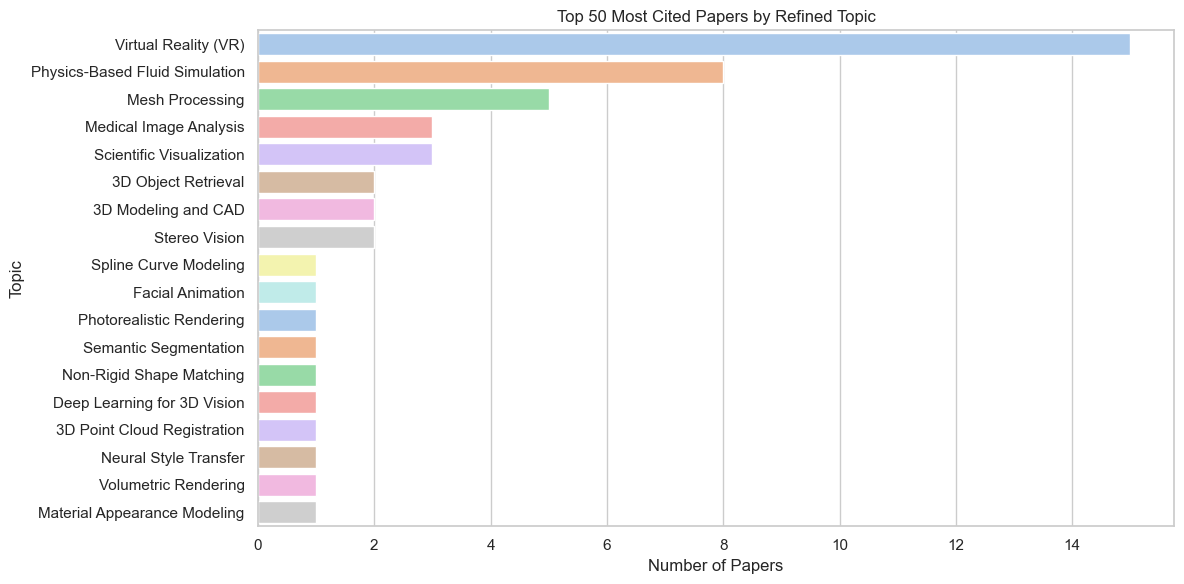

In [549]:
# ✅ Analyze top 50, reproducibility, etc.
top_50 = papers.sort_values(by="CitesPerYear", ascending=False).head(50)

# Example chart: topic distribution in top 50
topic_counts = top_50["Refined_Topic_Name"].value_counts().reset_index()
topic_counts.columns = ["Topic", "Paper Count"]

plt.figure(figsize=(12, 6))
sns.barplot(data=topic_counts, y="Topic", x="Paper Count", palette="pastel")
plt.title("Top 50 Most Cited Papers by Refined Topic")
plt.xlabel("Number of Papers")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

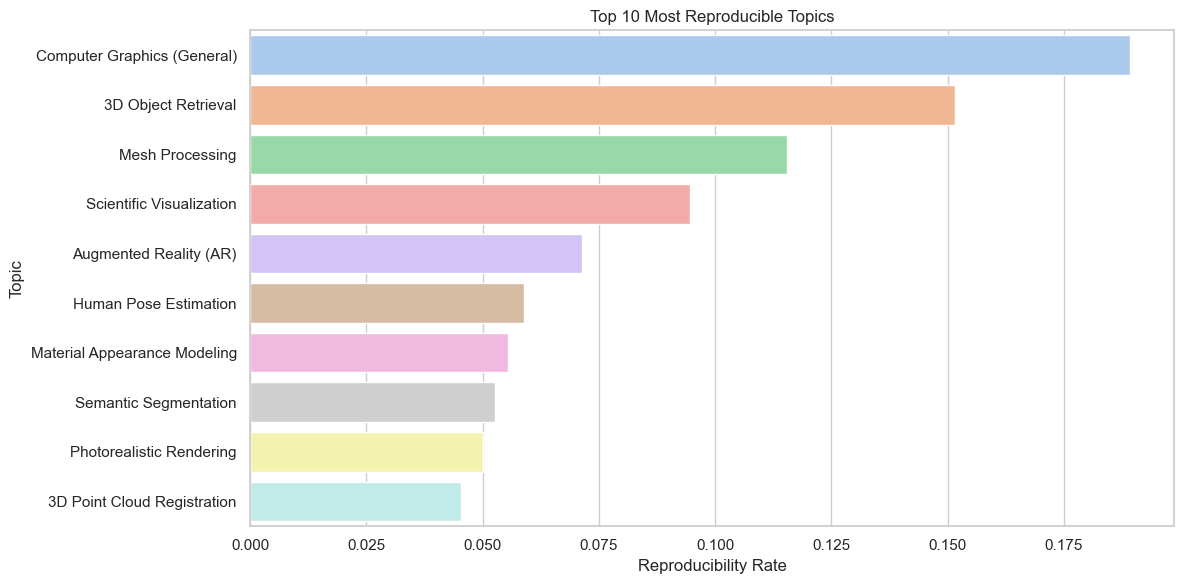

In [550]:
# Count reproducible papers per topic
reproducible_counts = papers[papers["IsReproducible?"] == 1].groupby("Topic").size()

# Count total papers per topic
total_counts = papers.groupby("Topic").size()

# Calculate reproducibility rate
reproducibility_rate = (reproducible_counts / total_counts).fillna(0).sort_values(ascending=False)

# Get top 10
top_10_reproducibility = reproducibility_rate.head(10).reset_index()
top_10_reproducibility.columns = ["Topic", "ReproducibilityRate"]

# Add refined topic names
top_10_reproducibility["Label"] = top_10_reproducibility["Topic"].map(refined_topic_labels)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_reproducibility, y="Label", x="ReproducibilityRate", palette="pastel")

plt.title("Top 10 Most Reproducible Topics")
plt.xlabel("Reproducibility Rate")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

<Figure size 1600x1800 with 0 Axes>

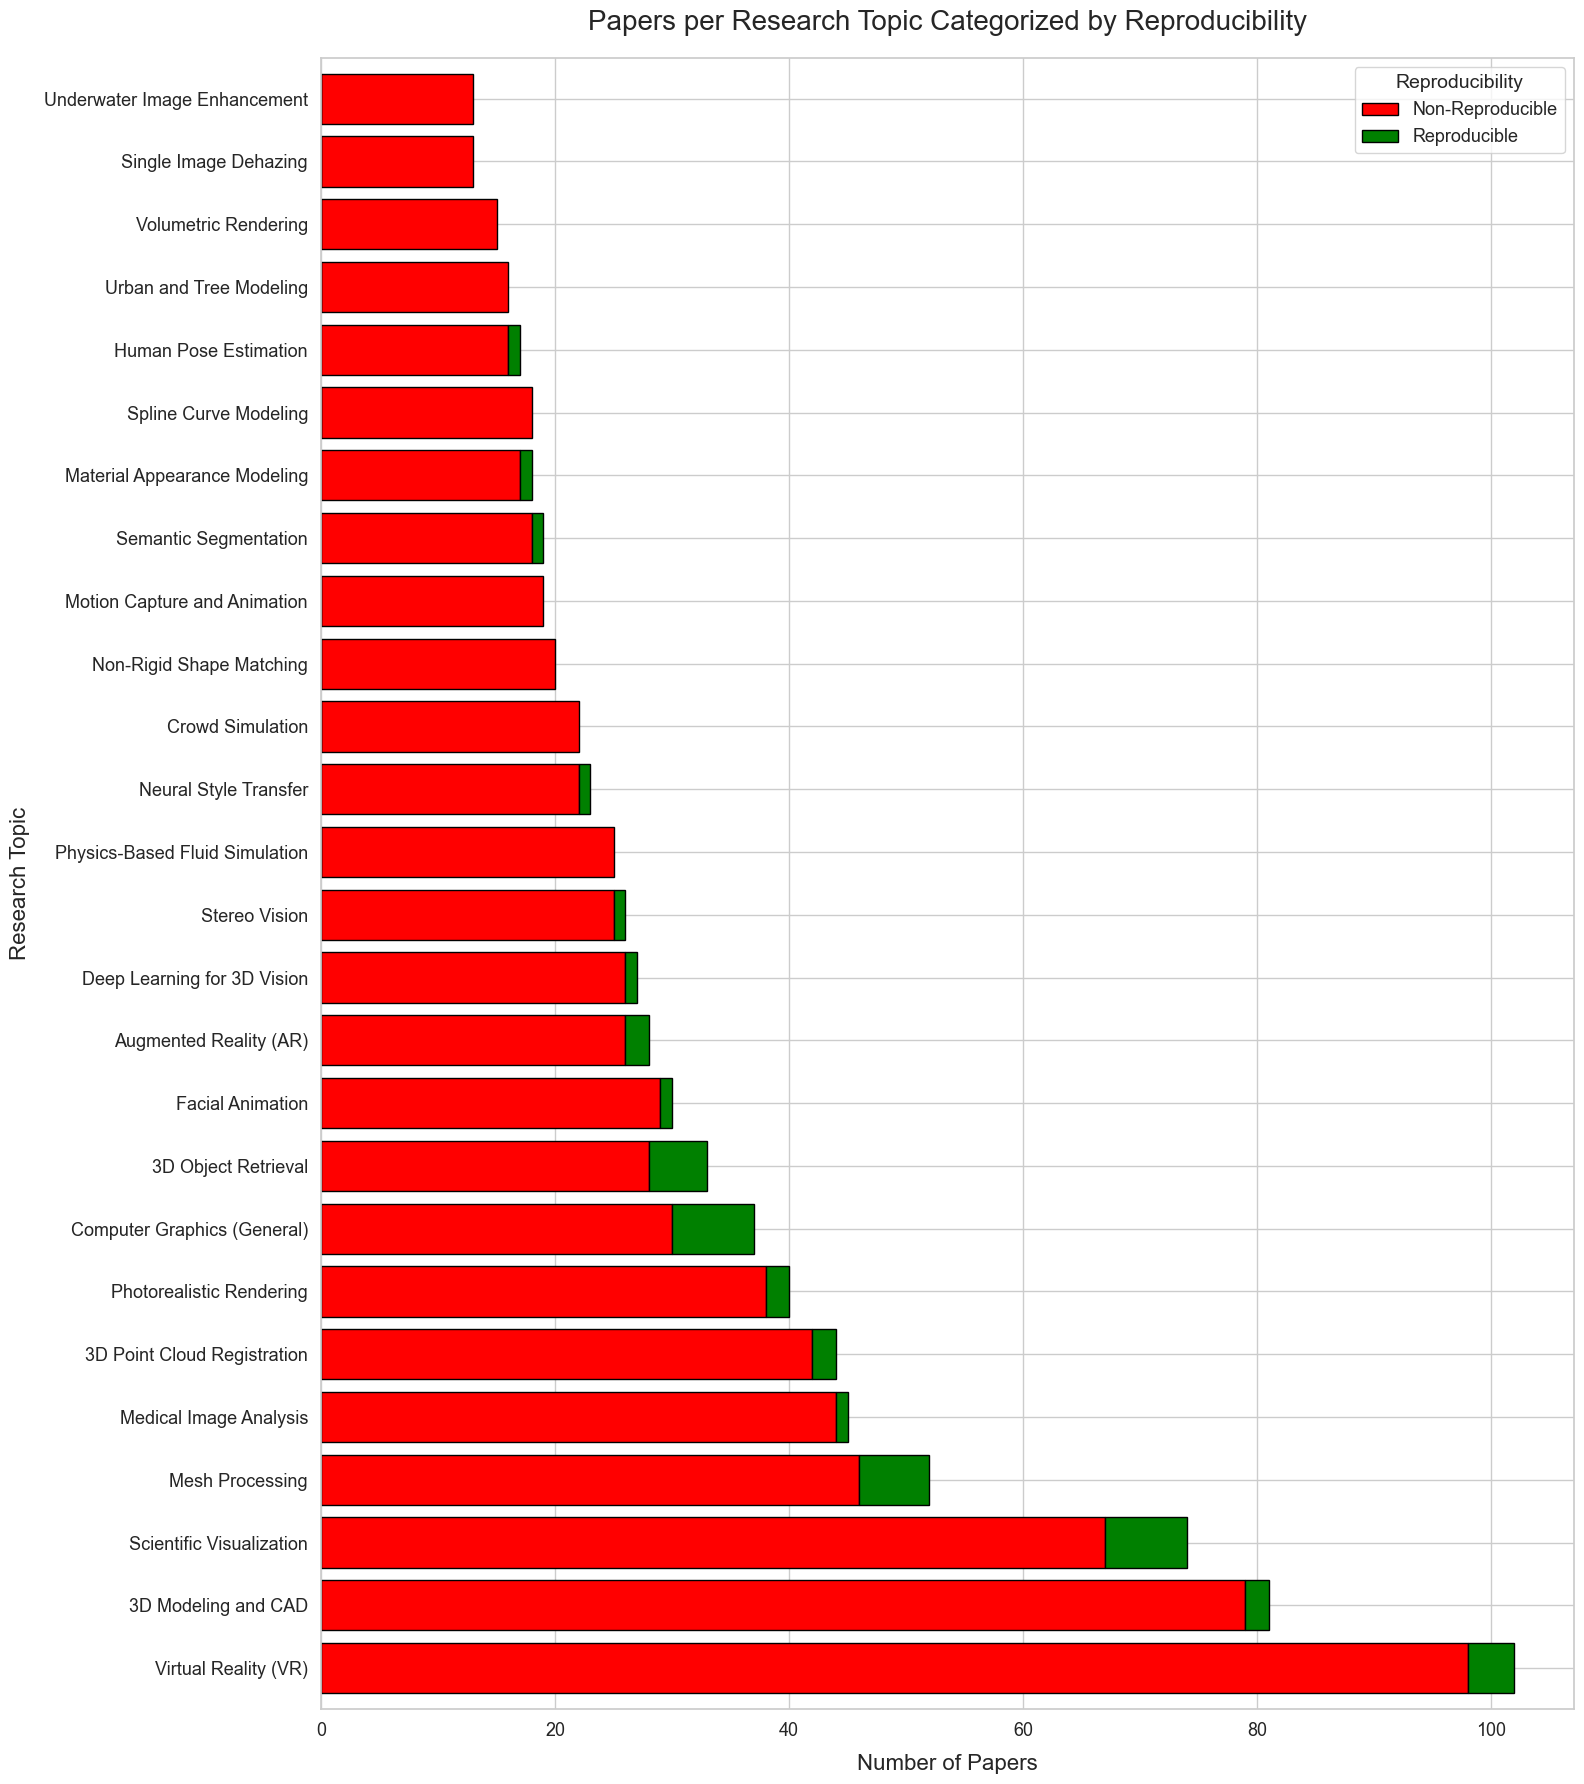

In [551]:
import matplotlib.pyplot as plt

# Map refined topic names
papers["Refined_Topic_Name"] = papers["Topic"].map(refined_topic_labels)

# Group counts by topic and reproducibility
reproducibility_summary = papers.groupby(["Refined_Topic_Name", "IsReproducible?"]).size().unstack(fill_value=0)

# Sort by total papers per topic
reproducibility_summary["Total"] = reproducibility_summary.sum(axis=1)
reproducibility_summary_horizontal = reproducibility_summary.sort_values(by="Total", ascending=False).drop(columns="Total")

# Plot horizontal stacked bar
plt.figure(figsize=(16, 18))  

# Plot horizontal stacked bars
reproducibility_summary_horizontal.plot(
    kind="barh",
    stacked=True,
    color=["red", "green"],
    edgecolor="black",
    figsize=(16, 18),  
    width=0.8  # thicker bars
)

# Customize axes and layout
plt.title("Papers per Research Topic Categorized by Reproducibility", fontsize=20, pad=20)
plt.xlabel("Number of Papers", fontsize=16, labelpad=10)
plt.ylabel("Research Topic", fontsize=16, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(title="Reproducibility", labels=["Non-Reproducible", "Reproducible"], fontsize=13, title_fontsize=14)
plt.tight_layout()
